In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Expectation Maximization Algorithm

Expectation maximization (EM) uses iterative optimization along with a latent variable model to obtain maximum likelihood estimates for models whose parameters are difficult to estimate directly. It may not be intuitive how introducing latent (missing) elements to a problem will facilitate its solution, but it works essentially by breaking the optimization into two steps:

1. generating an **expectation** over the missing variable(s) based on current estimates of parameters
2. **maximizing** the log-likelihood from the expectation step, thereby generating updated estimates of parameters

EM is particularly suited to estimating the parameters of *mixture models*, where we do not know from which component each observation is derived.

In general, suppose we have observed quantities $x = x_1,\ldots,x_n$ and unobserved (latent) quantities $z$ that are derived from some joint model:

$$(x,z) \sim P(x,z|\theta)$$

We are interested in obtaining the MLE for the marginal distribution of $X$:

$$x \sim P(x|\theta)$$

However, it is difficult to marginalize over $Z$ and maximize. EM gets around this by iteratively improving an initial estimate $\theta^{(0)}$.

## Example: Mixture of normals

Consider a set of observations, each of which has been drawn from one of two populations:

$$x^{(a)} \sim N(\mu_a, \sigma^2_a)$$
$$x^{(b)} \sim N(\mu_b, \sigma^2_b)$$

except we only observe the values for $x = [x^{(a)}, x^{(b)}]$, not the labels which identify which population they are derived from.

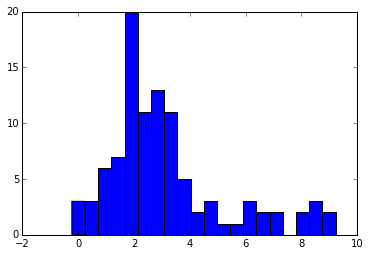

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# True parameter values
mu_true = [2, 5]
sigma_true = [1, 2]
psi_true = .4
n = 100

# Simulate from each distribution according to mixing proportion psi
z = np.random.binomial(1, psi_true, n)
x = [np.random.normal(mu_true[i], sigma_true[i]) for i in z]

_ = plt.hist(x, bins=20)

The observed data is then a finite mixture of normal distributions:

$$X = (1 - \psi)X^{(a)} + \psi X^{(b)}$$

This is a generative representation of the data, whereby unobserved labels $z_i$ are generated according to probability $\psi$. We might try to maximize the log likelihood of the joint distribution above, via maximum likelihood:

$$l(\theta) = \sum_i \log\left[(1 - \psi)\phi^{(a)}(x_i) + \psi \phi^{(b)}(x_i)\right] $$

$$\text{where } \theta = \{\psi, \mu^{(a)}, \sigma^{(a)}, \mu^{(b)}, \sigma^{(b)}\}$$

However, this function is very difficult to maximize, and turns out to be bimodal. A simpler approach is to consider the data labels to be unobserved data, and incorporate them into the model. This is generally called a *data augmentation* approach.

The joint distribution of $x$ and $z$ can be factorized into:

$$P(x_i,z_i) = P(x_i \,|\, z_i)P(z_i)$$

It is reasonable to model $z$ as:

$$\{z_i\} \sim \text{Bernoulli}(\psi)$$

where $\psi$ is the probability of membership in group "b" (hence, $1-\psi$ is the probability of group "a" membership). Note that this generalizes to $k$ components in the mixture, where $z_i \sim \text{Multinomial}(\psi)$ with $\psi$ of dimension $k-1$.

Clearly, the distribution of $x$ conditional on $z$ is:

$$(x_i | z_i = j) \sim N(\mu_j, \sigma_j)$$

If we knew the $\{z_i\}$, then we could simply use MLE to obtain estimates for the paramters of the model. However, we do not know the labels, which makes this a form of *unsupervised learning*.



### Algorithm

Continuing with the mixture of normals model as our example, we can apply the EM algorithm to estimate $\theta = \{\mu, \sigma, \psi\}$.

**Initiazlize** $\theta_0 = \{\mu_0, \sigma_0, \psi_0\}$

**Repeat until convergence:**

- **E-step**: guess the values of $\{z_i\}$

    Compute probabilities of group membership: $w_{ij} = P(z_i = j | x_i, \theta)$ for each group $j=1,\ldots,k$. This is done via Bayes' formula:
    
    $$P(z_i = j | x_i) = \frac{P(x_i | z_i=j) P(z_i=j)}{\sum_{l=1}^k P(x_i | z_i=l) P(z_i=l)}$$
    
    $\theta$ has been dropped for notational convenience.
    
- **M-step**: update estimates of parameters $\theta$

    $$\begin{aligned}\psi_j &= \frac{1}{m} \sum_i w_{ij} \\
      \mu_j &= \frac{\sum_i w_{ij} x_i}{\sum_i w_{ij}} \\
      \sigma_j &= \frac{\sum_i w_{ij}(x_i - \mu_j)^2}{\sum_i w_{ij}}
    \end{aligned}$$

### General formulation

Recall **Jensen's inequality**:

> Let $f$ be a convex function (*i.e.* $f^{\prime\prime} \ge 0$) of a random variable X. Then:
> $f(E[X]) \le E[f(X)]$

And when $f$ is *strictly* convex, then:

$$E[f(X)] = f(E[X]) \iff X = E[X]$$

with probability 1.

Consider again the joint density $P(x,z|\theta)$, where only $x$ is observed. We want to be able to maximize:

$$\begin{aligned}
l(x \,|\, \theta) &= \sum_i \log P(x_i \,|\, \theta) \\
&= \sum_i \log \sum_{z_i} P(x_i, z_i \,|\, \theta)
\end{aligned}$$

however, evaluating this is difficult when the $\{z_i\}$ are unobserved.

The EM algorithm iteratively calculates *lower bounds on the likelihood* for the current values of the parameters, then *maximizes the lower bound* to update the parameters.

Since $z_i$ is a random variable, perhaps we can construct its density $Q_i$ and use it to marginalize the joint likelihood:

$$\sum_i \log \sum_{z_i} P(x_i, z_i \,|\, \theta) = \sum_i \log \sum_{z_i} Q_i(z_i) \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)}$$

This turns the inner summation into an expectation.

$$\sum_i \log \sum_{z_i} Q_i(z_i) \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} = \sum_i \log E_{Q_i} \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right]$$

Now, if we apply Jensen's inequality (note that the logarithm is a *concave* function, so the inequality is reversed):

$$\begin{aligned}
\sum_i \log E_{Q_i} \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right] &\ge \sum_i  E_{Q_i} \log \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right] \\
&= \sum_i \sum_{z_i}  Q_i(z_i) \log \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right]
\end{aligned}$$

We need to ensure that the equality condition holds true, which we can do by choosing $Q_i$ appropriately. Specifically, we want a $Q_i$ such that:

$$\frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} = C$$

which implies:

$$Q_i(z_i) \propto P(x_i, z_i \,|\, \theta)$$

Since $Q_i$ is a density,

$$\begin{aligned}
Q_i(z_i) &= \frac{P(x_i, z_i \,|\, \theta)}{\sum_{z_i} P(x_i, z_i \,|\, \theta)} \\
&= \frac{P(x_i, z_i \,|\, \theta)}{P(x_i \,|\, \theta)} \\
&= P(z_i \,|\, x_i, \theta)
\end{aligned}$$

Returning to our normal mixture example:

For the **E-step** we need to identify $Q_i(z_i)$

$$Q_i(z_i) = P(z_i \,|\, x_i, \mu, \sigma, \psi)$$

Via Bayes' formula:

$$P(z_i=j \,|\, x_i) = \frac{P(x_i \,|\, z_i=j)P(z_i=j)}{\sum_l P(x_i \,|\, z_i=l)P(z_i=l)}$$

where $P(x_i \,|\, z_i=l)$ is just the $j$th Normal distribution of the mixture, and $P(z_i=l)$ is a multinomial probability.

This gives us:

$$P(z_i=1 \,|\, x_i) = \frac{\psi N(\mu_b, \sigma_b^2)}{\psi N(\mu_a, \sigma_a^2) + (1-\psi) N(\mu_b, \sigma_b^2)}$$

(recall that we are encoding `a=0` and `b=1`)

This can be implemented easily in Python:

In [6]:
from scipy.stats.distributions import norm

def Estep(x, mu, sigma, psi):
    a = psi * norm.pdf(x, mu[0], sigma[0])
    b = (1. - psi) * norm.pdf(x, mu[1], sigma[1])
    return b / (a + b)

In [7]:
Estep(4, mu_true, sigma_true, psi_true)

0.83023841958766409

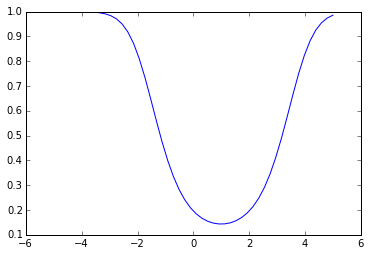

In [8]:
x_range = np.linspace(-5,5)
plt.plot(x_range, Estep(x_range, mu_true, sigma_true, psi_true))

For the **M-step** we need to maximize

$$\begin{aligned}\text{argmax}_{\mu,\Sigma, \psi}  \sum_i \sum_{z_i}  Q_i(z_i) \log \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right] \\
= \sum_i \sum_{z_i} w_{ij} \log \left[\frac{1}{\sqrt{2 \pi} \, |\Sigma_j|^{1/2} \, w_{ij}} e^{-\frac{1}{2} (x_i - \mu_j) \Sigma^{-1} (x_i - \mu_j))} \psi_j\right]
\end{aligned}$$

which we can show is

$$\begin{aligned}\psi_j &= \frac{1}{m} \sum_i w_{ij} \\
\mu_j &= \frac{\sum_i w_{ij} x_i}{\sum_i w_{ij}} \\
\sigma_j &= \frac{\sum_i w_{ij}(x_i - \mu_j)^2}{\sum_i w_{ij}}
\end{aligned}$$

This can be coded into Python as `Mstep`:

In [9]:
def Mstep(x, w):
    psi = np.mean(w) 
    
    mu = [np.sum((1-w) * x)/np.sum(1-w), np.sum(w * x)/np.sum(w)]
    
    sigma = [np.sqrt(np.sum((1-w) * (x - mu[0])**2)/np.sum(1-w)), 
             np.sqrt(np.sum(w * (x - mu[1])**2)/np.sum(w))]
    
    return mu, sigma, psi

In [10]:
# Initialize values
mu = np.random.normal(size=2)
sigma = np.random.uniform(0, 10, 2)
psi = np.random.random()

# Stopping criterion
crit = 1e-4

# Convergence flag
converged = False

# Loop until converged
while not converged:
    
    # E-step
    w = Estep(x, mu, sigma, psi)
    # M-step
    mu_new, sigma_new, psi_new = Mstep(x, w)
    
    # Check convergence
    converged = ((np.abs(psi_new - psi) < crit) 
                 & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                 & np.all(np.abs((np.array(sigma_new) - np.array(sigma)) < crit)))
    mu, sigma, psi = mu_new, sigma_new, psi_new
                
print('A: N({0:.4f}, {1:.4f})\nB: N({2:.4f}, {3:.4f})\npsi: {4:.4f}'.format(
                        mu_new[0], sigma_new[0], mu_new[1], sigma_new[1], psi_new))

A: N(2.1789, 0.7876)
B: N(4.2046, 2.5749)
psi: 0.4720


### Exercise: Zero-inflated data

Code the EM algorithm to estimate the paramters of a zero-inflated Poisson (ZIP) model.

(array([ 75.,   0.,   7.,   0.,  10.,   0.,   5.,   0.,   3.]),
 array([ 0.        ,  0.44444444,  0.88888889,  1.33333333,  1.77777778,
         2.22222222,  2.66666667,  3.11111111,  3.55555556,  4.        ]),
 <a list of 9 Patch objects>)

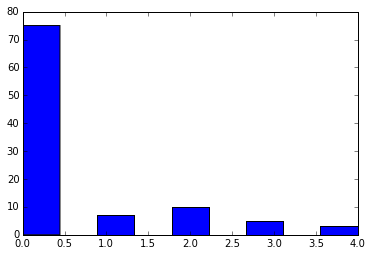

In [9]:
import numpy as np

# True parameter values
mu_true = 1.5
psi_true = .4
n = 100

# Simulate some data
data = np.array([np.random.poisson(mu_true)*(np.random.random()<psi_true) for i in range(n)])
plt.hist(data, bins=9)

In [5]:
from scipy.stats.distributions import poisson

def Estep(x, mu, psi):
    a = (1-psi)*(x==0)
    b = psi * poisson.pmf(x, mu)
    return b / (a + b)

In [6]:
def Mstep(x, w):
    psi = np.mean(w) 
    
    mu = [np.sum(w * x)/np.sum(w)]
    
    return mu, psi

In [7]:
# Initialize values
import numpy as np
mu = np.random.normal(size=2)
sigma = np.random.uniform(0, 10, 2)
psi = np.random.random()

# Stopping criterion
crit = 1e-4

# Convergence flag
converged = False

# Loop until converged
while not converged:
    
    # E-step
    w = Estep(x, mu, psi)
    # M-step
    mu_new, psi_new = Mstep(x, w)
    
    # Check convergence
    converged = ((np.abs(psi_new - psi) < crit) 
                 & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                 & np.all(np.abs((np.array(sigma_new) - np.array(sigma)) < crit)))
    
    import pdb; pdb.set_trace()
    mu,psi = mu_new, psi_new
                
print('A: N({0:.4f}, {1:.4f})\nB: N({2:.4f}, {3:.4f})\npsi: {4:.4f}'.format(
                        mu_new[0], sigma_new[0], mu_new[1], sigma_new[1], psi_new))

NameError: name 'x' is not defined

## Notes

The EM algorithm guaranteees that $P(x \,|\, \theta^{(i+1)}) \ge  P(x \,|\,  \theta^{(i)})$, however there is no guarantee that we will obtain the true MLE (due to multimodality).

Convergence of the EM algorithm can be slow, and it works best for likelihoods of the [exponential family of distributions](https://en.wikipedia.org/wiki/Exponential_family).

In a Bayesian context, EM can also be used to obtain a maximum a posteriori (MAP) estimate for $\theta$.

### Sources

[Python for Signal Processing](http://python-for-signal-processing.blogspot.com/2012/11/expectation-maximization-expectation.html)

[Stanford University's Machine Learning (Coursera)](https://www.coursera.org/course/ml)